In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [47]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [col for col in numeric_cols if col.lower() not in ['id', 'index', 'movieid', 'movie_id', 'cluster']]
    print(f"Dataset cargado: {file_path} | {df.shape[0]} filas, {len(feature_cols)} columnas numéricas.")
    return df, feature_cols

In [48]:
df_combined = pd.read_parquet("movies_combined_features.parquet")
print(f"\nCombined cargado: {df_combined.shape} columnas = {list(df_combined.columns)}")

X_combined = np.vstack(df_combined['features'].values)
feature_cols_combined = [f"feature_{i+1}" for i in range(X_combined.shape[1])]
df_combined_expanded = pd.DataFrame(X_combined, columns=feature_cols_combined)
print(f"Combined expandido: {df_combined_expanded.shape}")


Combined cargado: (5831, 3) columnas = ['movieId', 'title', 'features']
Combined expandido: (5831, 305)


In [49]:
df_pca, features_pca = load_data("movies_pca_features.csv")
df_umap, features_umap = load_data("movies_umap.csv")

print("\n=== VERIFICACIÓN DE ARCHIVOS DE ENTRADA ===")
print(f"Columnas PCA: {df_pca.columns.tolist()[:5]}...")
print(f"Columnas UMAP: {df_umap.columns.tolist()[:5]}...")

for df_name in ['pca', 'umap']:
    df = df_pca if df_name == 'pca' else df_umap
    meta_cols_present = [c for c in df.columns if c in ['movieId', 'title', 'genres', 'poster_url', 'poster_path', 'year']]
    if meta_cols_present:
        print(f"{df_name.upper()} tiene metadatos {meta_cols_present}, eliminándolos...")
        if df_name == 'pca':
            df_pca = df_pca.drop(columns=meta_cols_present)
            features_pca = [c for c in features_pca if c not in meta_cols_present]
        else:
            df_umap = df_umap.drop(columns=meta_cols_present)
            features_umap = [c for c in features_umap if c not in meta_cols_present]

print(f"\n PCA: {len(features_pca)} features | UMAP: {len(features_umap)} features")

Dataset cargado: movies_pca_features.csv | 5831 filas, 90 columnas numéricas.
Dataset cargado: movies_umap.csv | 5831 filas, 50 columnas numéricas.

=== VERIFICACIÓN DE ARCHIVOS DE ENTRADA ===
Columnas PCA: ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5']...
Columnas UMAP: ['UMAP_1', 'UMAP_2', 'UMAP_3', 'UMAP_4', 'UMAP_5']...

 PCA: 90 features | UMAP: 50 features


In [50]:
def initialize_centroids_plus_plus(X, k):
    n_samples = X.shape[0]
    centroids = [X[np.random.randint(n_samples)]]
    for _ in range(k - 1):
        distances = np.array([min([np.inner(c-x, c-x) for c in centroids]) for x in X])
        probs = distances / distances.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()
        for j, p in enumerate(cumulative_probs):
            if r < p:
                centroids.append(X[j])
                break
    return np.array(centroids)

def kmeans_from_scratch(X, k=5, max_iters=100, random_state=42):
    np.random.seed(random_state)
    n_samples, n_features = X.shape
    centroids = initialize_centroids_plus_plus(X, k)
    labels = np.zeros(n_samples)
    for iteration in range(max_iters):
        old_centroids = centroids.copy()
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)
        for i in range(k):
            if np.sum(labels == i) > 0:
                centroids[i] = X[labels == i].mean(axis=0)
        if np.allclose(old_centroids, centroids):
            break
    inertia = sum(np.sum((X[labels == i] - centroids[i])**2) for i in range(k))
    return centroids, labels, iteration + 1, inertia

In [51]:
def elbow_method(X, max_k=15, method='sklearn'):
    inertias, silhouette_scores = [], []
    k_range = range(2, max_k + 1)
    print(f"\nCalculando métricas para k=2 hasta k={max_k}...")
    for k in k_range:
        if method == 'sklearn':
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X)
            inertia = kmeans.inertia_
        else:
            _, labels, _, inertia = kmeans_from_scratch(X, k=k)
        inertias.append(inertia)
        if len(X) < 10000:
            silhouette_scores.append(silhouette_score(X, labels))
        if k % 3 == 0:
            msg = f"k={k}: Inercia={inertia:.2f}"
            if len(X) < 10000:
                msg += f", Silhouette={silhouette_scores[-1]:.3f}"
            print(msg)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_title('Método del Codo', fontsize=14, fontweight='bold')
    if silhouette_scores:
        axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    axes[1].set_title('Método Silhouette', fontsize=14, fontweight='bold')
    plt.show()
    return inertias, silhouette_scores if len(X) < 10000 else None

def evaluate_clustering(X, labels, k):
    print(f"\nEVALUACIÓN DEL CLUSTERING (k={k})\n")
    silhouette = silhouette_score(X, labels) if len(X) < 10000 else None
    db_index = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    if silhouette is not None:
        print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Calinski-Harabasz Score: {ch_score:.4f}")
    print("\nDistribución de películas por cluster:")
    unique, counts = np.unique(labels, return_counts=True)
    for c, count in zip(unique, counts):
        print(f"  Cluster {c}: {count} películas ({100*count/len(labels):.1f}%)")
    return {'silhouette': silhouette, 'davies_bouldin': db_index, 'calinski_harabasz': ch_score}

def visualize_clusters_2d(X, labels, centroids=None, title="Clustering Results"):
    plt.figure(figsize=(12, 8))
    X_2d = X[:, :2] if X.shape[1] >= 2 else X
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis', alpha=0.6, s=50)
    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, edgecolors='black', linewidths=2)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.colorbar(scatter, label='Cluster ID')
    plt.show()

In [52]:
def run_kmeans_analysis(df, feature_cols, dataset_name, optimal_k=None):
    print(f"\nANÁLISIS K-MEANS: {dataset_name}\n")
    X = df[feature_cols].values
    X_scaled = StandardScaler().fit_transform(X)
    print(f"Datos preparados: {X_scaled.shape}")

    if optimal_k is None:
        inertias, silhouettes = elbow_method(X_scaled, max_k=15)
        optimal_k = np.argmax(silhouettes) + 2 if silhouettes is not None else 5
        print(f"\nK sugerido por Silhouette: {optimal_k}")

    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    metrics = evaluate_clustering(X_scaled, labels, optimal_k)
    visualize_clusters_2d(X_scaled, labels, kmeans.cluster_centers_, f"{dataset_name} (k={optimal_k})")

    df_result = df.copy()
    df_result['cluster'] = labels
    
    return df_result, {'k': optimal_k, 'metrics': metrics}

In [53]:
def inject_meta_and_export(df_result_raw, parquet_meta, out_name):
    assert len(df_result_raw) == len(parquet_meta), "Longitudes distintas al inyectar meta."
    
    meta_cols = [c for c in ["movieId", "title", "genres", "poster_url", "poster_path", "year"] 
                 if c in parquet_meta.columns]
    meta = parquet_meta[meta_cols].reset_index(drop=True)
    
    df_export = pd.concat([meta, df_result_raw.reset_index(drop=True)], axis=1)
    
    front = [c for c in ["movieId", "title", "genres", "poster_url", "poster_path", "year", "cluster"] 
             if c in df_export.columns]
    rest = [c for c in df_export.columns if c not in front]
    df_export = df_export[front + rest]
    
    df_export.to_csv(out_name, index=False, encoding="utf-8")
    print(f" Exportado {out_name} con shape {df_export.shape}")
    return df_export


ANÁLISIS K-MEANS: pca_features

Datos preparados: (5831, 90)

Calculando métricas para k=2 hasta k=15...
k=3: Inercia=515214.04, Silhouette=0.025
k=6: Inercia=503996.57, Silhouette=-0.046
k=9: Inercia=493345.11, Silhouette=-0.058
k=12: Inercia=483632.82, Silhouette=-0.054
k=15: Inercia=474213.48, Silhouette=-0.061


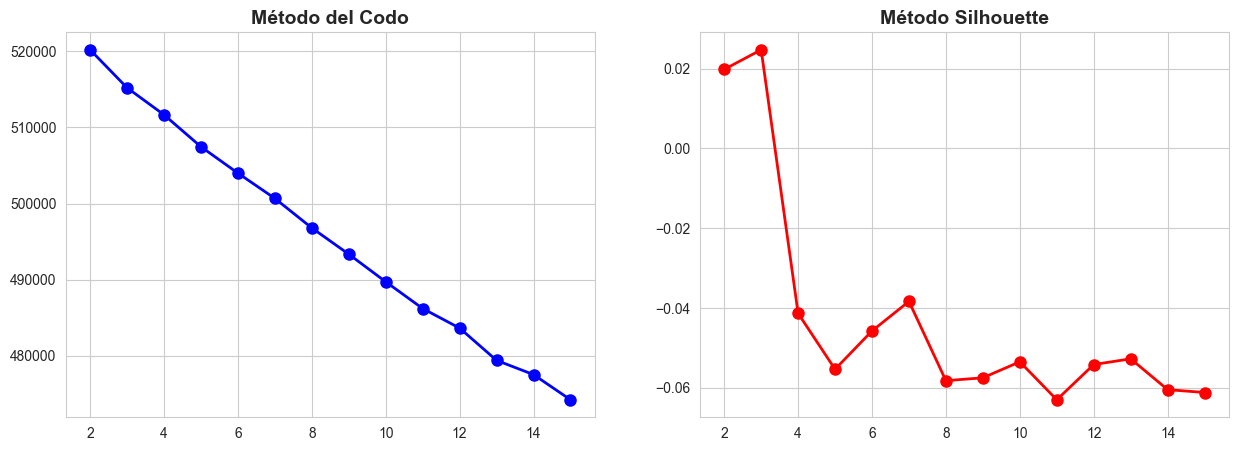


K sugerido por Silhouette: 3

EVALUACIÓN DEL CLUSTERING (k=3)

Silhouette Score: 0.0247
Davies-Bouldin Index: 6.0533
Calinski-Harabasz Score: 54.1607

Distribución de películas por cluster:
  Cluster 0: 379 películas (6.5%)
  Cluster 1: 908 películas (15.6%)
  Cluster 2: 4544 películas (77.9%)


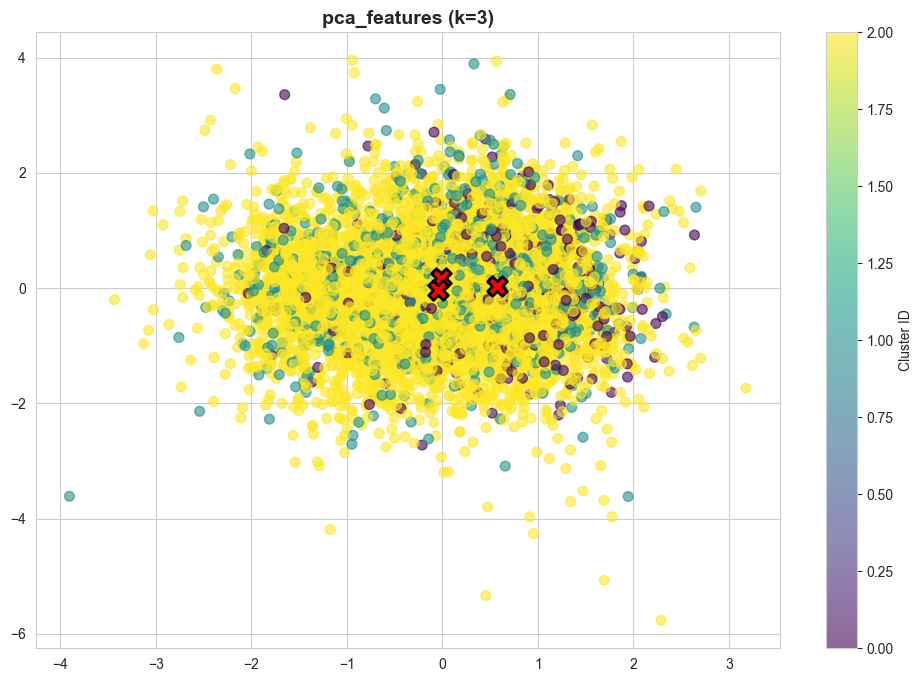

 Exportado pca_features_clustered.csv con shape (5831, 93)

ANÁLISIS K-MEANS: umap_features

Datos preparados: (5831, 50)

Calculando métricas para k=2 hasta k=15...
k=3: Inercia=137049.89, Silhouette=0.338
k=6: Inercia=87712.05, Silhouette=0.301
k=9: Inercia=67823.32, Silhouette=0.279
k=12: Inercia=56606.87, Silhouette=0.252
k=15: Inercia=48299.12, Silhouette=0.262


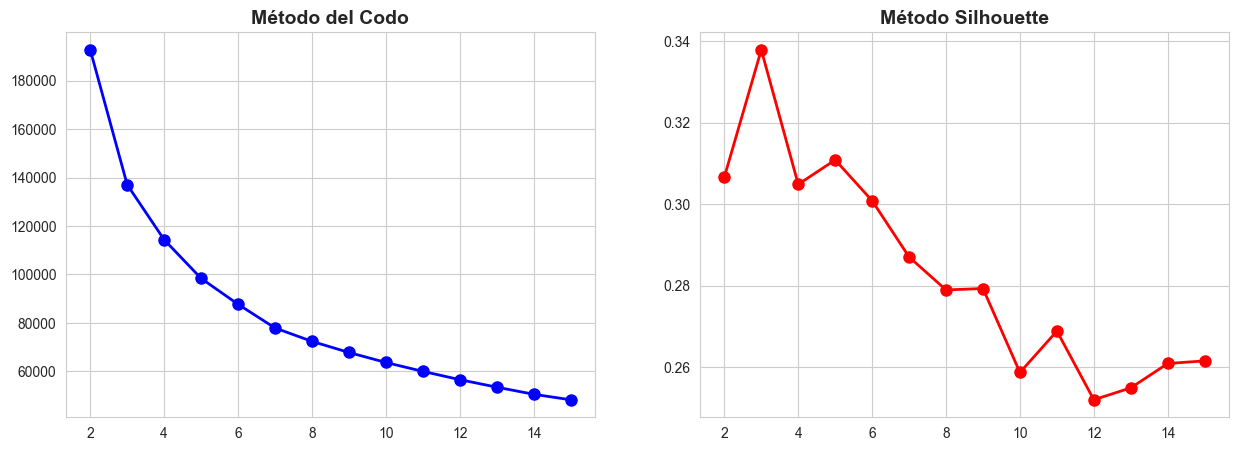


K sugerido por Silhouette: 3

EVALUACIÓN DEL CLUSTERING (k=3)

Silhouette Score: 0.3379
Davies-Bouldin Index: 1.0565
Calinski-Harabasz Score: 3285.0335

Distribución de películas por cluster:
  Cluster 0: 1290 películas (22.1%)
  Cluster 1: 2525 películas (43.3%)
  Cluster 2: 2016 películas (34.6%)


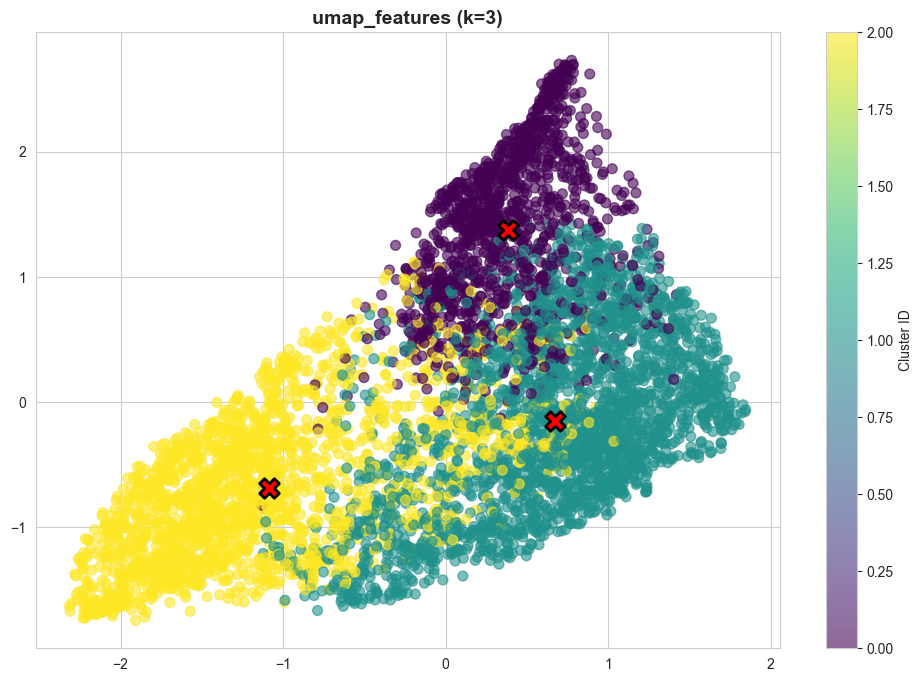

 Exportado umap_features_clustered.csv con shape (5831, 53)

ANÁLISIS K-MEANS: combined_features

Datos preparados: (5831, 305)

Calculando métricas para k=2 hasta k=15...
k=3: Inercia=1475702.62, Silhouette=0.102
k=6: Inercia=1337475.50, Silhouette=0.074
k=9: Inercia=1275888.00, Silhouette=0.050
k=12: Inercia=1236144.00, Silhouette=0.046
k=15: Inercia=1207709.88, Silhouette=0.036


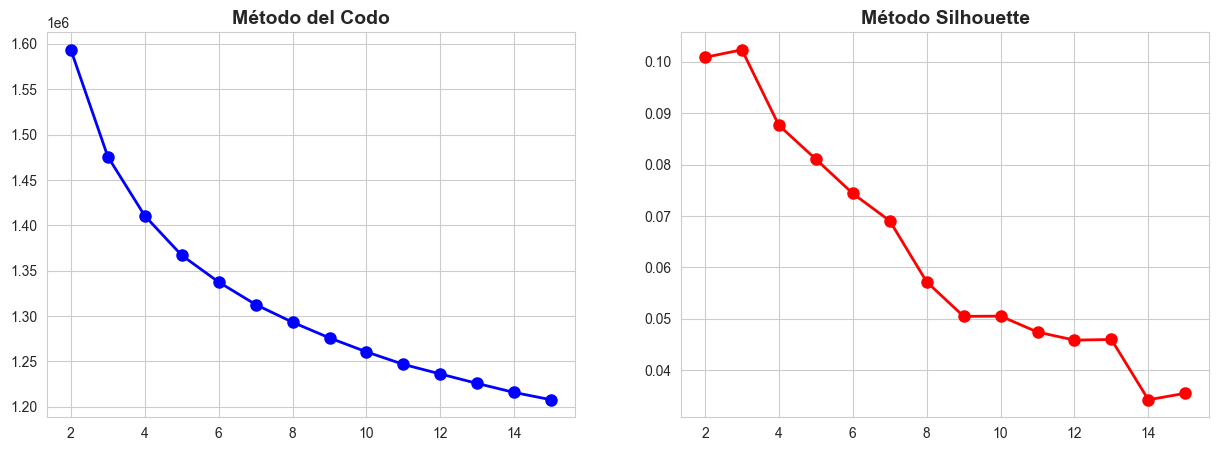


K sugerido por Silhouette: 3

EVALUACIÓN DEL CLUSTERING (k=3)

Silhouette Score: 0.1024
Davies-Bouldin Index: 2.5795
Calinski-Harabasz Score: 597.8307

Distribución de películas por cluster:
  Cluster 0: 1756 películas (30.1%)
  Cluster 1: 2090 películas (35.8%)
  Cluster 2: 1985 películas (34.0%)


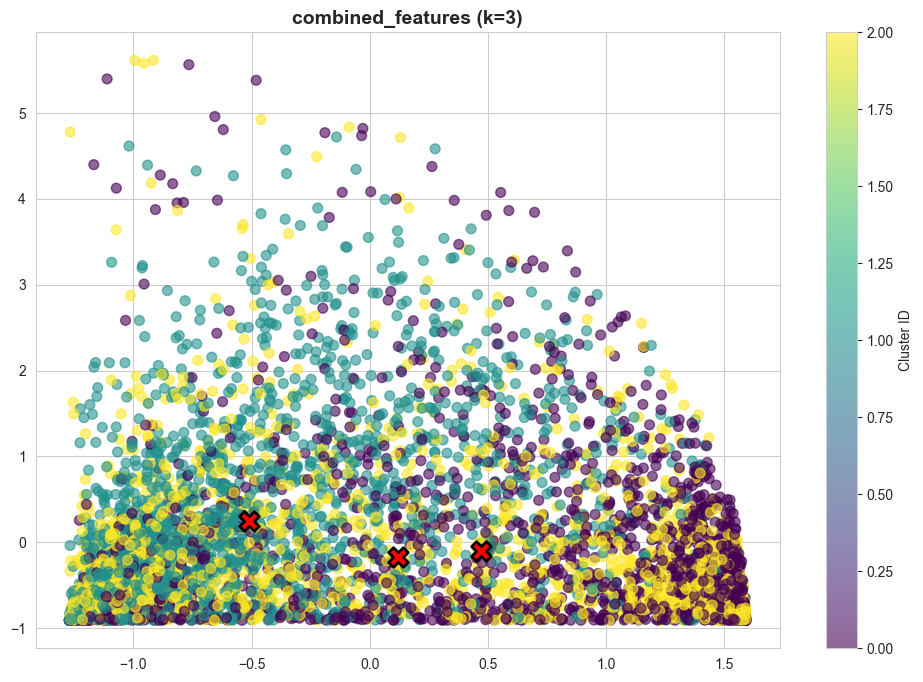

 Exportado combined_features_clustered.csv con shape (5831, 308)


,movieId,title,cluster,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305
0,619,Ed (1996),1,0.190584,0.097977,0.076738,0.298000,0.279853,0.503232,0.355127,...,18.407625,25.177420,24.953079,20.834311,21.648094,21.070381,27.643696,15.366569,15.498533,16.070381
1,33826,Saint Ralph (2004),2,0.700600,0.025043,0.017595,0.319024,0.469603,0.334459,0.186902,...,21.799309,32.655708,32.673012,18.475779,15.164360,15.762976,24.660900,14.147058,15.015571,19.667820
2,140289,Men & Chicken (2015),1,0.583132,0.353574,0.238463,0.570694,0.368418,0.095918,0.034753,...,15.583924,25.451536,30.732861,24.191490,25.274231,24.073286,26.834515,17.820332,13.541371,16.193853
3,2868,Fright Night Part II (1988),1,0.080335,0.012563,0.007420,0.009714,0.005434,0.008755,0.007488,...,11.574783,23.525269,27.278713,21.667688,20.880550,22.504848,34.405819,15.856560,10.575804,14.531394
4,27826,Touch of Pink (2004),2,0.499249,0.258052,0.262440,0.431758,0.361134,0.386138,0.028905,...,17.624161,29.917786,26.947987,22.135906,18.714766,15.714766,15.550336,12.644296,12.812080,15.714766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5826,47382,Step Up (2006),2,0.771414,0.244369,0.129117,0.145266,0.120126,0.233501,0.360535,...,11.891243,27.218220,34.245056,20.213984,13.193502,15.004944,19.958334,12.471751,8.696327,14.300141
5827,30749,Hotel Rwanda (2004),2,0.239246,0.355852,0.450544,0.519844,0.246479,0.423418,0.264880,...,12.708126,26.542288,24.811775,17.643450,14.038142,13.316750,17.478441,9.540630,10.636816,11.676617
5828,8450,Anthony Adverse (1936),2,0.023545,0.033032,0.039039,0.055682,0.038284,0.079908,0.114364,...,15.095993,27.468281,27.724541,19.542570,17.735392,17.222036,25.064274,12.269616,11.297997,15.211185
5829,8983,House of Flying Daggers (Shi mian mai fu) (2004),1,0.454374,0.343453,0.272067,0.538712,0.195881,0.296089,0.374003,...,12.907895,24.750412,26.914885,20.372122,19.892681,23.603207,30.196957,15.425164,11.474917,15.528372


In [54]:
pca_raw, results_pca = run_kmeans_analysis(df_pca, features_pca, "pca_features")
inject_meta_and_export(pca_raw, df_combined, "pca_features_clustered.csv")

umap_raw, results_umap = run_kmeans_analysis(df_umap, features_umap, "umap_features")
inject_meta_and_export(umap_raw, df_combined, "umap_features_clustered.csv")

comb_raw, results_combined = run_kmeans_analysis(df_combined_expanded, feature_cols_combined, "combined_features")
inject_meta_and_export(comb_raw, df_combined, "combined_features_clustered.csv")



In [55]:
comparison_df = pd.DataFrame({
    'Método': ['PCA', 'UMAP', 'COMBINED'],
    'K óptimo': [results_pca['k'], results_umap['k'], results_combined['k']],
    'Davies-Bouldin': [
        results_pca['metrics']['davies_bouldin'],
        results_umap['metrics']['davies_bouldin'],
        results_combined['metrics']['davies_bouldin']
    ],
    'Calinski-Harabasz': [
        results_pca['metrics']['calinski_harabasz'],
        results_umap['metrics']['calinski_harabasz'],
        results_combined['metrics']['calinski_harabasz']
    ]
})


print("COMPARACIÓN FINAL: PCA vs UMAP vs COMBINED")

print(comparison_df.to_string(index=False))

COMPARACIÓN FINAL: PCA vs UMAP vs COMBINED
  Método  K óptimo  Davies-Bouldin  Calinski-Harabasz
     PCA         3        6.053270          54.160703
    UMAP         3        1.056529        3285.033481
COMBINED         3        2.579535         597.830750


In [56]:
best_method = comparison_df.loc[comparison_df['Davies-Bouldin'].idxmin(), 'Método']
print(f"\n Mejor método: {best_method} (menor Davies-Bouldin Index)")

# Copiar el mejor archivo
file_map = {
    'PCA': 'pca_features_clustered.csv',
    'UMAP': 'umap_features_clustered.csv',
    'COMBINED': 'combined_features_clustered.csv'
}
best_file = file_map[best_method]
shutil.copy(best_file, "best_method_clustered.csv")
print(f" Archivo del mejor método copiado a: best_method_clustered.csv")


 Mejor método: UMAP (menor Davies-Bouldin Index)
 Archivo del mejor método copiado a: best_method_clustered.csv
